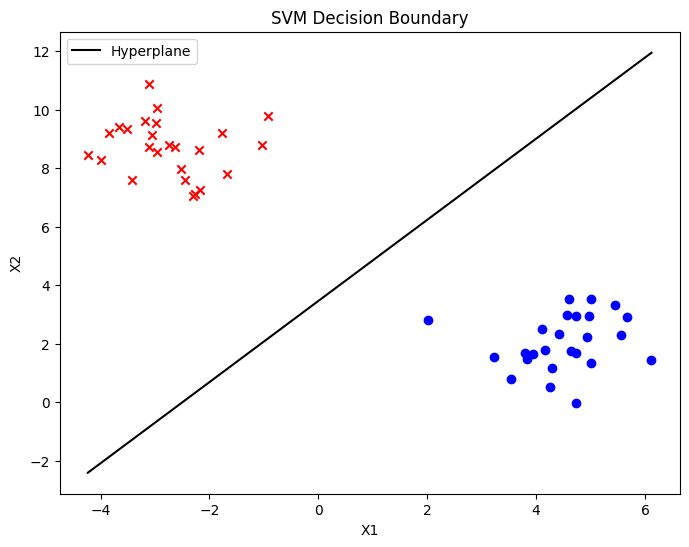

Optimal alphas: [1.78839937e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.96070651e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.67361738e-19 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.66598397e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.03843887e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.36686484e-03
 0.00000000e+00 0.00000000e+00 5.53076165e-03 1.76312680e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.82567934e-03
 0.00000000e+00 0.00000000e+00]
Bias term: 0.5182777863246205
Weight vector: [ 0.2078461  -0.14983284]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate synthetic linearly separable data
X, y = make_blobs(n_samples=50, centers=2, n_features=2, random_state=42)

# Convert labels from {0,1} to {-1,1} for SVM compatibility
y = 2 * y - 1

# Initialize variables
n_samples, n_features = X.shape
alpha = np.zeros(n_samples)
b = 0
C = 1.0  # Regularization parameter
tol = 1e-5  # Tolerance for stopping criteria
max_iter = 1000  # Maximum iterations

# Linear kernel function
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

# Compute kernel matrix
K = np.array([[linear_kernel(x_i, x_j) for x_j in X] for x_i in X])

def smo():
    global alpha, b
    for _ in range(max_iter):
        num_changed_alphas = 0
        for i in range(n_samples):
            E_i = np.sum(alpha * y * K[i, :]) + b - y[i]
            if (y[i] * E_i < -tol and alpha[i] < C) or (y[i] * E_i > tol and alpha[i] > 0):
                j = np.random.choice([idx for idx in range(n_samples) if idx != i])
                E_j = np.sum(alpha * y * K[j, :]) + b - y[j]
                
                alpha_i_old, alpha_j_old = alpha[i], alpha[j]
                
                if y[i] != y[j]:
                    L, H = max(0, alpha[j] - alpha[i]), min(C, C + alpha[j] - alpha[i])
                else:
                    L, H = max(0, alpha[i] + alpha[j] - C), min(C, alpha[i] + alpha[j])
                
                if L == H:
                    continue
                
                eta = 2 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    continue
                
                alpha[j] -= y[j] * (E_i - E_j) / eta
                alpha[j] = np.clip(alpha[j], L, H)
                
                if abs(alpha[j] - alpha_j_old) < tol:
                    continue
                
                alpha[i] += y[i] * y[j] * (alpha_j_old - alpha[j])
                
                b1 = b - E_i - y[i] * (alpha[i] - alpha_i_old) * K[i, i] - y[j] * (alpha[j] - alpha_j_old) * K[i, j]
                b2 = b - E_j - y[i] * (alpha[i] - alpha_i_old) * K[i, j] - y[j] * (alpha[j] - alpha_j_old) * K[j, j]
                
                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
                
                num_changed_alphas += 1
        
        if num_changed_alphas == 0:
            break

smo()

# Compute weight vector
w = np.sum((alpha * y)[:, np.newaxis] * X, axis=0)

# Plot data and decision boundary
plt.figure(figsize=(8, 6))
for i, point in enumerate(X):
    if y[i] == 1:
        plt.scatter(point[0], point[1], color='blue', marker='o')
    else:
        plt.scatter(point[0], point[1], color='red', marker='x')

# Decision boundary
x1_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2_vals = (-w[0] * x1_vals - b) / w[1]
plt.plot(x1_vals, x2_vals, color='black', label='Hyperplane')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('SVM Decision Boundary')
plt.show()

print("Optimal alphas:", alpha)
print("Bias term:", b)
print("Weight vector:", w)
